# Run a ROMS-MARBL Blueprint with C-star CLI

This example demonstrates how to launch a regional ocean model simulation, including biogeochemical processes, using a ROMS-MARBL blueprint. You may want to refer to the [Terminology and Concepts page](../terminology.rst) for a broader overview of what a blueprint is and how it fits into the bigger picture.\


## Prerequisities

In order to run this notebook, you need to have first:

- [Installed](../installation.rst) `C-Star`
- Activated the environment in your terminal with `conda activate cstar_env`
- If you want to run this example notebook, first create an `ipykernel` by running this command in your terminal:

  `python -m ipykernel install --user --name cstar_env --display-name cstar_env`

- Launched this notebook from your terminal with `jupyter lab docs/tutorials/tutorial_bp.ipynb` and selected the `cstar_env` in the kernel dropdown within the notebook.

<div class="alert alert-info">

Note

This short example is runnable on a MacOS laptop with the default C-Star configuration settings. If you run this example or another use case on an HPC, please visit the  [configuration](../configuration.rst) to learn how to integrate C-Star with SLURM and configure other important behaviors.
</div>

To run the ROMS-MARBL application, the following files first need to be created specifically for the simulation you'd like to run:
* Input data files (e.g. surface and boundary conditions, initial conditions, grid definitions, etc., typically as `.nc` files)
* Compile-time files (`.opt`) that define parameters and toggle options in the ROMS code
* Runtime files (`.in`, `marbl_*`) files that specify additional settings

For this example, we provide a blueprint along with all files needed to run the simulation.\
The [blueprint in this example](wales_toy_blueprint.yaml) resides in the same directory as this notebook, and can also be viewed alongside the data it points to in our [examples repository](https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example).

To create your own domain, consider using this blueprint as a template and creating your own files using [Roms-Tools](https://roms-tools.readthedocs.io/en/latest/index.html) for input data files, or [C-SON Forge](https://cworthy-ocean.github.io/cson-forge/installation/) for all necessary files (input, compile-time, run-time, and blueprint).

## Inspect and run the simulation

<div class="alert alert-info">

Note

`C-Star` is intended to be run as a command line utility. We have formulated this tutorial as a Jupyter Notebook to easily step through commands and see results as they run, using the `!` Jupyter directive to run terminal and CLI commands. All of these commands could be similarly run from a terminal shell without the `!`.
</div>

### Define the blueprint

We can print the content of the blueprint with `cat wio_toy_blueprint.yaml`, and see that each of the attributes described in the [blueprints page](../blueprints.rst) are defined.

To reference the file architecture and what this blueprint points to, see this [repository](https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/tree/main/wio-toy-domain).

The blueprint below describes a toy domain of the Western Indian Ocean. It has a coarse resolution of 400 km, with grid cell dimensions 20x20 and 10 vertical layers. Rivers and tides are included in the simulation (as defined in the .opt files). The input data files are already created and their location online is indicated under `data:` `location:`. 

For these data files, we use default input data generated by roms-tools, relying on ERA5 and GLORYS data for surface forces, initial conditions, and boundary forces, as well as a unified BGC climatology dataset for surface and boundary forces. TPXO data was used for tides, and the Dai and Trenberth global river dataset was used for rivers.

The data files are partitioned into 2x5 tiles, and the model is run for 30 minutes for quick results on a laptop.

**Print out the blueprint contents:**

In [1]:
!cat wio_toy_blueprint.yaml

name: wio_toy
description: wio toy domain for laptop
application: roms_marbl
state: draft
valid_start_date: 2012-01-01
valid_end_date: 2012-01-02

code:
  roms:
    location: https://github.com/CWorthy-ocean/ucla-roms.git
    branch: a338198af93a7b4cfa8f320a23f0f5623bc18152
  marbl:
    location: https://github.com/marbl-ecosys/MARBL.git
    branch: marbl0.45.0

  run_time:
    location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
    branch: main
    filter:
      directory: wio-toy-domain/runtime_code
      files:
        - cson_roms-marbl_v0.1_wio-toy_10procs.in
        - marbl_in
        - marbl_tracer_output_list
        - marbl_diagnostic_output_list
  compile_time:
    location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
    branch: main
    filter:
      directory: wio-toy-domain/compile_time_code
      files:
        - bgc.opt
        - bulk_frc.opt
        - cdr_frc.opt
        - cppdefs.opt
        - diagnostics.opt
  

## Explanation of blueprint sections

For more details, see the [Blueprints](../blueprints) section of these docs.

### Models
The specific versions of the models (ROMS and MARBL) used for the simulation are definded under the `code` block, where `location` can also point to specific forks or local clones of the repository, and `branch` or `commit` can be used to specify a unique instance of the code.

### Runtime code
For the files needed at the run-time of the model, the blueprint can either point to a `git` repository online, as shown above under `run_time`, or to a local directory (see example [here](../blueprints.rst#romsmarblblueprint-example)). Note that the provided ROMS runtime file `*.in` is used as a template and modified by C-Star; scientific values like `bottom_drag` and `S-coord` are preserved, but runtime specifics that are related to execution details (e.g. pointers to netCDF forcing files, output location, and time extent of the simulation) are edited to align with the details provided in the blueprint.

### Compile-time code
Like the run-time files, the blueprint can point to an online repository or a local directory for files that should be pulled in and compiled with the model. These files typically include `*.opt` and `cppdefs` with a variety of parameters related to how the model is run. Any files specified here will override the relevant files from the `code` repositories.

### Forcing files
The location of each of the input data files are specified in their respective sections - `grid`, `intitial_conditions`, `tidal`, `surface`, etc.\
`C-Star` supports pre-partitioned files (which is recommended for large domains where partitioning can take a long time). For this use case, point `location` to the first of the partitioned files (e.g. `.../base_name.000.nc`) and set the `partitioned: true` flag. C-Star will find the rest of the partitions for you.\
C-Star can also partition the files for you, by specifying `partitioned: false` and pointing `location` to the unpartitioned source file.\

The files will be paritioned according to the parameters defined under `partitioning` (i.e. `n_procs_x`, `n_procs_y`). However, if the files are already partitioned, these parameters must match how many horizontal (`n_procs_x`) and vertical (`n_procs_y`) partitions they were divided into. 

### Model and Runtime Parameters
The time step to be used in the model is specified under `model_params`. This example uses a 900 second time step.\
The start and end date of the simulation are defined under `runtime_params` along with the location in which to store the output files from both the simulation run and the `C-Star` orchestration. The start and end dates must be within the range of the `valid_start_date` and `valid_end_date`. 

## Check the blueprint for syntax

Once the blueprint is complete, we can use `C-Star` to proofread it. The `cstar blueprint` command has a functionality `check` to confirm that the syntax of the blueprint YAML is correct and all necessary parameters are included.\
This does not check for things such as whether the input files exist, it simply checks that the blueprint is syntactically correct.

In [2]:
!cstar blueprint check wio_toy_blueprint.yaml

The blueprint is valid


If the output directory remains from a previous run, it may need to be remove before running the simulation.

In [3]:
!rm -rf ~/cstar/wio_toy_blueprint/

## Run the model from the blueprint

In [4]:
!cstar blueprint run wio_toy_blueprint.yaml

Executing blueprint in a worker service
2026-02-18 21:30:52,877 [INFO] - simulation.py:1220 - 🛠️ Configuring ROMSSimulation
2026-02-18 21:30:52,877 [INFO] - simulation.py:1223 - 🔧 Setting up ROMSExternalCodeBase...
2026-02-18 21:31:01,996 [INFO] - simulation.py:1223 - 🔧 Setting up MARBLExternalCodeBase...
2026-02-18 21:31:15,531 [INFO] - simulation.py:1237 - 📦 Fetching compile-time code...
2026-02-18 21:31:16,456 [INFO] - simulation.py:1242 - 📦 Fetching runtime code... 
2026-02-18 21:31:16,814 [INFO] - simulation.py:1247 - 📦 Fetching input datasets...
2026-02-18 21:31:32,974 [INFO] - input_dataset.py:225 - Partitioning /Users/eilerman/cstar/wio_toy_blueprint/input/input_datasets/cson_roms-marbl_v0.1_wio-toy_10procs_grid.nc into (2,5)
2026-02-18 21:31:33,400 [INFO] - input_dataset.py:225 - Partitioning /Users/eilerman/cstar/wio_toy_blueprint/input/input_datasets/cson_roms-marbl_v0.1_wio-toy_10procs_initial_conditions.nc into (2,5)
2026-02-18 21:31:33,609 [INFO] - input_dataset.py:225 - 

## Simulation results

All of the output files from the model runs can be found in subdirectories under the `output_dir` specified in the blueprint. For this blueprint, they have been placed under your home directory, in `~/cstar/wio_toy_blueprint`.

The contents in each of the subdirecties are:
- **inputs/**
  - **codebase**:  The model source code pulled from the location specified in the blueprint, and compiled by C-Star.
  - **compile_time_code**:  The compile-time files specified in the blueprint and the ROMS executable resulting from compiling the code under `codebase`.
  - **input_datasets**:  The partitioned input data files used in the model. These are either links to user-paritioned files specified in the blueprint, or partitioned versions of unpartitioned files specified in the blueprint.
  - **runtime_code**:  The runtime files provided by the user (i.e. `marbl_*`, `.in` files), and the `C-Star`-modified `.in` file.
- **logs**:  The `.out` log files. This comes from the output of the model. Errors in this file will come directly from `ROMS` or `MARBL`.
- **work**: temporary files used by C-Star
- **output**:  The raw unpartitioned output files from the models.
- **joined_output**:  Joined output result files. These files can be inspected using ROMS-Tools](https://roms-tools.readthedocs.io/en/latest/plotting_roms_output.html#), `ncview`, or other tools of your choice.


### Example visualization

Here we illustrate how you could begin to examine your model output using [ROMS-Tools](https://roms-tools.readthedocs.io/en/latest/plotting_roms_output.html#). For this example, we will make a simple plot of the sea surface temperature. Feel free to explore the other variables by examining `roms_output.ds`, or load some of the other output files in the `joined_output` directory, to view the BGC variables!


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


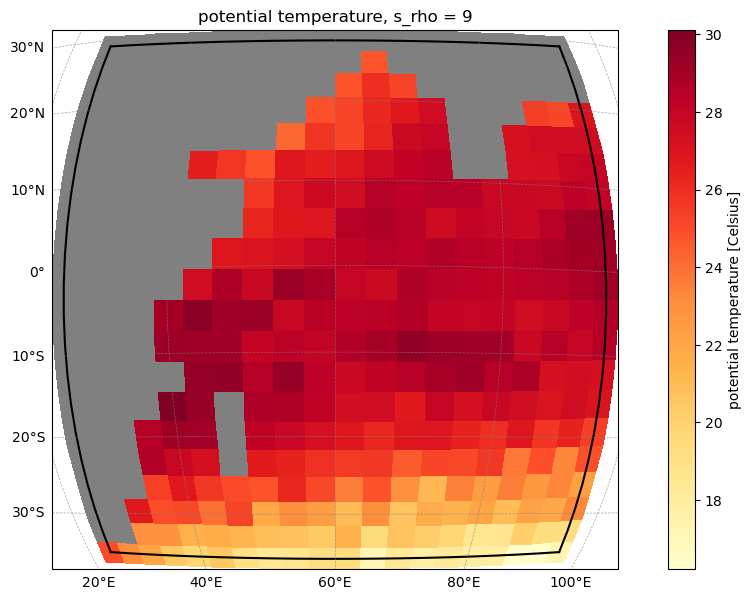

In [5]:
from roms_tools import Grid, ROMSOutput
grid = Grid.from_file("~/cstar/wio_toy_blueprint/input/input_datasets/cson_roms-marbl_v0.1_wio-toy_10procs_grid.nc")
roms_output = ROMSOutput(
    grid=grid,
    path=[
        "~/cstar/wio_toy_blueprint/joined_output/output_his.20120101000000.nc",
    ])
roms_output.plot("temp", time=0, s=-1)


## Next Steps

If you'd like to see C-Star run the same steps but for a different blueprint (pointing to a different area of the globe), feel free to try what you've learned, but with the [Wales blueprint](wales_toy_blueprint.yaml) in this same directory!

If you'd like to try making your own domain and blueprint, consider giving the CSON-Forge repository a try.

If you want to try to orchestrate a set of simulations, please look forward to the Laptop-Runnable Workplans guide (coming very soon!).